In [190]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt

import http
import requests
import yfinance as yf

## Get data and preprocessing

In [191]:
api_key = "b5569108b07766dcb23028a5de53e385"

In [192]:
# This is how we get the series_id

# request_for_allReleases = f"https://api.stlouisfed.org/fred/series/search?search_text=volatility+index&api_key={api_key}&file_type=json"
# data = requests.get(request_for_allReleases).json()
# data

In [193]:
request_for_VIX = f"https://api.stlouisfed.org/fred/series/observations?series_id=VIXCLS&api_key={api_key}&file_type=json"
vix_data = requests.get(request_for_VIX).json()

request_for_VXV = f"https://api.stlouisfed.org/fred/series/observations?series_id=VXVCLS&api_key={api_key}&file_type=json"
vxv_data = requests.get(request_for_VXV).json()

vix_value = []
vix_date = []
for data in vix_data["observations"]:
    if (data["value"] != "."):
        vix_value.append(float(data["value"]))
        vix_date.append(data["date"])

vxv_value = []
vxv_date = []
for data in vxv_data["observations"]:
    if (data["value"] != "."):
        vxv_value.append(float(data["value"]))
        vxv_date.append(data["date"])

offset = len(vix_value) - len(vxv_value)

vix_value = vix_value[offset - 4:]
vix_date = vix_date[offset - 4:]

for i in range(len(vix_date)):
    if (i < len(vxv_date) and vix_date[i] != vxv_date[i]):
        vix_value.remove(vix_value[i])
        vix_date.remove(vix_date[i])

        i -= 1

vix_value = np.array(vix_value)
vxv_value = np.array(vxv_value)


In [194]:
symbol = '^GSPC'
df = yf.download(symbol, start="2007-12-05", end="2022-10-20")
SP500 = df["Close"].to_numpy()

symbol = 'IEF'
df = yf.download(symbol, start="2007-12-05", end="2022-10-20")
IEF = df["Adj Close"].to_numpy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [195]:
print("vix value:", vix_value.shape)
print("vxv value:", vxv_value.shape)
print("vix date:", len(vix_date))
print("vxv date:", len(vxv_date))
print("S&P500:", SP500.shape)
print("IEF:", IEF.shape)

vix value: (3746,)
vxv value: (3746,)
vix date: 3746
vxv date: 3746
S&P500: (3746,)
IEF: (3746,)


## Signal detection

In [196]:
signal = vix_value - vxv_value

new_signal = signal > 0
new_signal = np.diff(new_signal.astype(int))
new_signal = np.insert(new_signal, 0, 0.0, axis = 0)

## Back test

In [197]:
init_money = 1000
init_storage = 0.0
fee_rate = 0.01
money_profit = 0.0002

In [198]:
def trade(money, storage, side, price):
    # print(money, storage, side)
    if side == -1 and money > 0:
        # print("money", money, "storage", storage, "price", price, "asset", money + storage * SP500[0])
        money *= (1 - fee_rate)
        storage *= (1 - fee_rate)
        storage = money / price
        money = 0
        # print("money", money, "storage", storage, "price", price, "asset", money + storage * SP500[0])
        # print("buy ---------------------------")
        
    elif side == 1 and storage > 0:
        # print("money", money, "storage", storage, "price", price, "asset", money + storage * SP500[0])
        money *= (1 - fee_rate)
        storage *= (1 - fee_rate)
        money = storage * price
        storage = 0
        # print("money", money, "storage", storage, "price", price, "asset", money + storage * SP500[0])
        # print("---------------------------")
        # print("sell ---------------------------")
    # print(money, storage, side)
    return money, storage


In [199]:
money = init_money
storage = init_storage


aggregate_profits = []
money, storage = trade(money, storage, -1, SP500[0])
aggregate_profits.append((money + storage * SP500[0] - init_money) / init_money)
# print(1, new_signal[0], SP500[0])

for i in range(1, len(SP500)):
    # print(i + 1, new_signal[i], SP500[i])
    if (money > 0):
        money *= (1 + money_profit)
    money, storage = trade(money, storage, new_signal[i], SP500[i])
    aggregate_profits.append((money * (1 + money_profit) + storage * SP500[i] - init_money) / init_money)
    # print(i + 1, (money * (1 + money_profit) + storage * SP500[i]) / init_money)
    # if i > 100:
    #     break
aggregate_profits = np.array(aggregate_profits) + 1


APY: 8.81327204698541
Aggregate 350.9772014086598


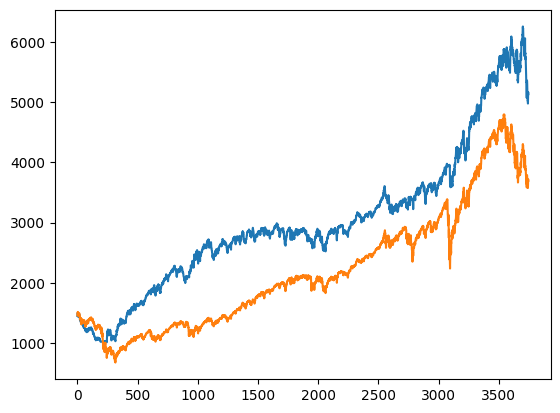

In [200]:
year_num = len(vxv_date) / 252
print("APY:", (aggregate_profits[-1] ** (1 / year_num) - 1) * 100)
print("Aggregate", aggregate_profits[-1] * 100)
plt.plot(aggregate_profits*SP500[0])
plt.plot(SP500)
plt.show()

In [201]:
# window_size = 260
# off = 260
# start = 0

# profit = []
# while start + window_size < vix_value.shape[0]:
#     money = init_money
#     storage = init_storage

#     local_signal = new_signal[start:start + window_size] != 0
#     local_SP500 = SP500[start:start + window_size][local_signal]
#     local_signal = (new_signal[start:start + window_size])[local_signal]

#     trade(money, storage, -1, SP500[start])

#     for i in range(len(local_signal)):
#         money, storage = trade(money, storage, local_signal[i], local_SP500[i])

#     profit.append((money + storage * SP500[start + window_size - 1] - init_money) / init_money)

#     start += off

---------------------
APY: 10.331500551273209


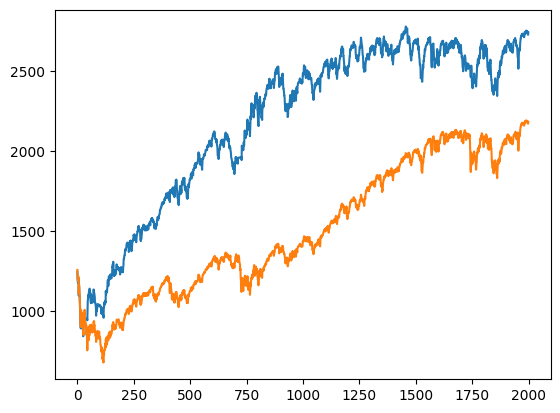

---------------------
APY: 11.139495831591283


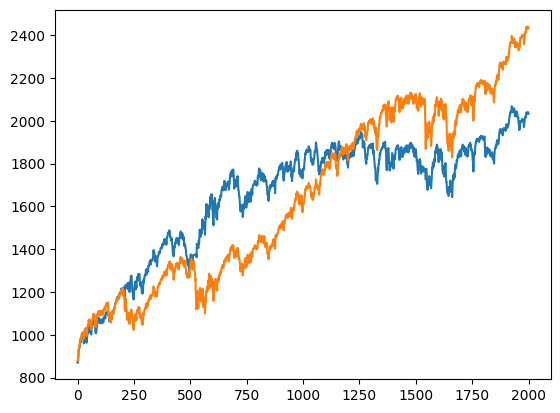

---------------------
APY: 6.729377953927829


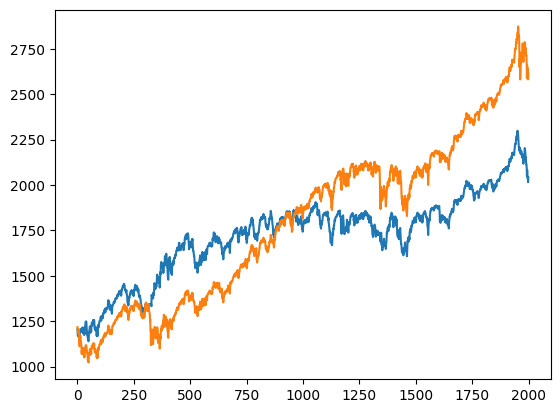

---------------------
APY: 5.326838869165829


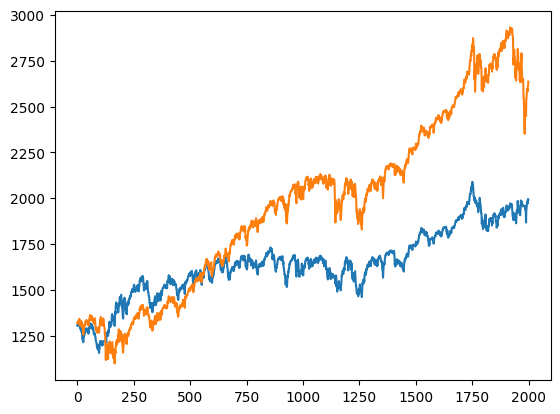

---------------------
APY: 5.38336375796824


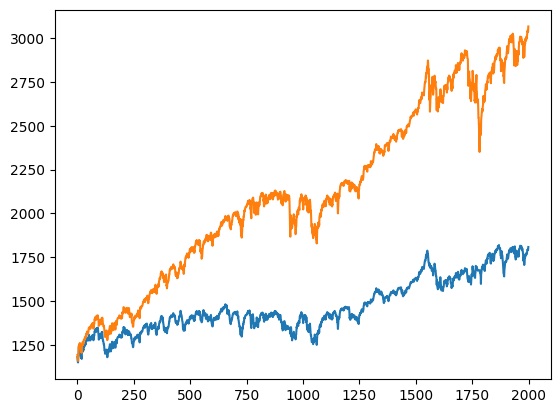

---------------------
APY: 6.1925937568643175


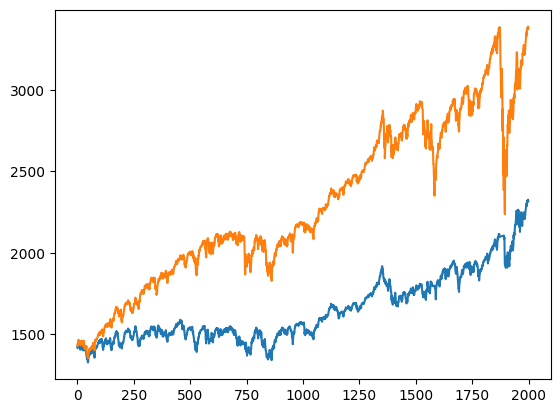

---------------------
APY: 8.509288028354112


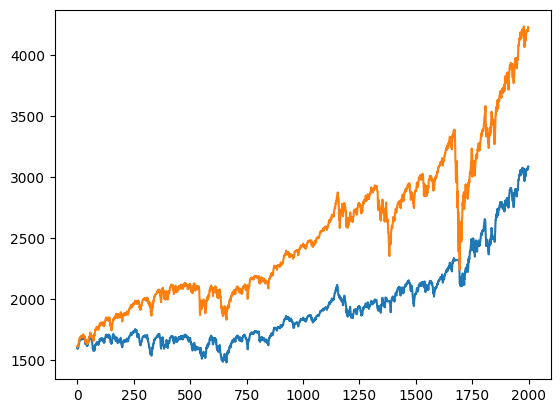

---------------------
APY: 10.004729200946304


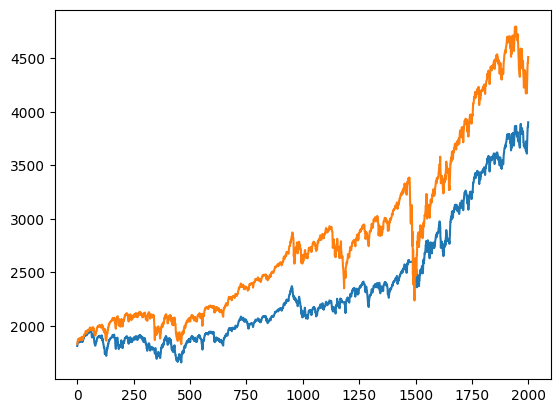

In [202]:
window = 2000
APY = []
for ind in range(200, len(SP500), 200):
    if (ind + window >= len(SP500)):
        break
    money = init_money
    storage = init_storage


    aggregate_profits = []
    money, storage = trade(money, storage, -1, SP500[ind])
    # print(money, storage)
    aggregate_profits.append((money + storage * SP500[ind] - init_money) / init_money)
    # print(1, new_signal[0], SP500[0])

    for i in range(ind + 1, ind + window):
        # print(i + 1, new_signal[i], SP500[i])
        if (money > 0):
            money *= (1 + money_profit)
        money, storage = trade(money, storage, new_signal[i], SP500[i])
        aggregate_profits.append((money * (1 + money_profit) + storage * SP500[i] - init_money) / init_money)
        # print(money, storage)
        # print(i + 1, (money * (1 + money_profit) + storage * SP500[i]) / init_money)
        # if i > 100:
        #     break
    aggregate_profits = np.array(aggregate_profits) + 1
    # year_num = len(vxv_date) / 252
    year_num = window / 252
    print("---------------------")
    print("APY:", (aggregate_profits[-1] ** (1 / year_num) - 1) * 100)
    plt.plot(aggregate_profits*SP500[ind])
    plt.plot(SP500[ind:ind+window])
    plt.show()
    APY.append((aggregate_profits[-1] ** (1 / year_num) - 1) * 100)
    # print(aggregate_profits[:30])

In [203]:
apy = np.array(APY)
print("mean:", apy.mean(), "std:", apy.std(), "median:", np.median(apy))

mean: 7.95214849376139 std: 2.1916345953172343 median: 7.61933299114097
